# XAI Random Forest SHAP

## 1 Import libraries

Import libraries for data loading, model loading, TF-IDF vectoriser loading, SHAP, and visualisation.

In [10]:
# Core libraries
import os
import pandas as pd
import numpy as np
import time

# For loading scikit-learn models and vectorisers
import joblib

# For loading .npz sparse matrices
from scipy.sparse import load_npz

# The SHAP library
import shap

# For gdown to download files from Google Drive
import gdown

# Ensure matplotlib is available for SHAP plots
import matplotlib.pyplot as plt

# Initialise SHAP JavaScript visualisation in the notebook
shap.initjs()

pd.set_option('display.max_colwidth', 150)

## 2. Load Model, Vectorizer, and Data for Explanation

Load:

1. The saved Random Forest model (`phishing_random_forest_model.joblib`).
2. The saved TF-IDF vectoriser (`tfidf_vectorizer.joblib`).
3. The TF-IDF features and labels for the internal test set (`X_test_features.npz`, `y_test_labels.csv`).
4. Optionally, the original text data for the test set (`test_corpus.csv`) to link explanations back to actual text.

In [11]:
# --- Define Google Drive File IDs and Local Filenames ---
RF_MODEL_GDRIVE_FILE_ID = '1S46OnX0vvYSL8UyvimiSBXm7WKg2SeEp'
RF_MODEL_LOCAL_FILENAME = 'phishing_random_forest_model.joblib'

TFIDF_VECTORIZER_GDRIVE_FILE_ID = '1JioXYHa5Roi4WxacfSJWa4LXPJPzltFA'
TFIDF_VECTORIZER_LOCAL_FILENAME = 'tfidf_vectorizer.joblib'

X_TEST_FEATURES_GDRIVE_FILE_ID = '1Uy8XTpCQRV5CckNj3EmfbXcIDFD3OSff'
X_TEST_FEATURES_LOCAL_FILENAME = 'X_test_features.npz'

Y_TEST_LABELS_GDRIVE_FILE_ID = '1qvdVxKBSfRdUzjeHX6iQUpxAOMPbulYD'
Y_TEST_LABELS_LOCAL_FILENAME = 'y_test_labels.csv'

TEST_CORPUS_CSV_GDRIVE_FILE_ID = '1bR5kipQPB21VSvjpLypbzkQAP0v-sAaw'
TEST_CORPUS_CSV_LOCAL_FILENAME = 'test_corpus.csv'

files_to_download_shap = [
    {'id': RF_MODEL_GDRIVE_FILE_ID, 'name': RF_MODEL_LOCAL_FILENAME},
    {'id': TFIDF_VECTORIZER_GDRIVE_FILE_ID, 'name': TFIDF_VECTORIZER_LOCAL_FILENAME},
    {'id': X_TEST_FEATURES_GDRIVE_FILE_ID, 'name': X_TEST_FEATURES_LOCAL_FILENAME},
    {'id': Y_TEST_LABELS_GDRIVE_FILE_ID, 'name': Y_TEST_LABELS_LOCAL_FILENAME},
    {'id': TEST_CORPUS_CSV_GDRIVE_FILE_ID, 'name': TEST_CORPUS_CSV_LOCAL_FILENAME}
]

# --- gdown download function ---
def download_file_from_gdrive(file_id, local_filename):
    if not os.path.exists(local_filename):
        print(f"Downloading {local_filename} from Google Drive...")
        gdrive_url = f'https://drive.google.com/uc?id={file_id}'

        try:
            gdown.download(gdrive_url, local_filename, quiet=False)
            print(f"{local_filename} downloaded successfully.")

        except Exception as e:
            print(f"ERROR downloading {local_filename}: {e}. Check File ID and share settings.")
            return False

    else:
        print(f"{local_filename} already exists in Colab runtime.")

    return os.path.exists(local_filename)

# --- Download all necessary files ---
all_components_loaded = True
for file_info in files_to_download_shap:
    if not download_file_from_gdrive(file_info['id'], file_info['name']):

        # Set to false if any download fails
        all_components_loaded = False

# --- Initialize variables ---
rf_model, tfidf_vectorizer = None, None
X_test_tfidf, y_test_labels = None, None
df_test_text = pd.DataFrame()

# Initialise
FEATURE_TEXT_COLUMN = None

# --- Load components if all downloads were attempted (check individual file existence now) ---
if all_components_loaded:
    print("\nAttempting to load all components...")
    try:
        if os.path.exists(RF_MODEL_LOCAL_FILENAME):
            rf_model = joblib.load(RF_MODEL_LOCAL_FILENAME)
            print(f"Loaded RF model: {RF_MODEL_LOCAL_FILENAME}")

        else:
          all_components_loaded = False
          print(f"ERROR: {RF_MODEL_LOCAL_FILENAME} not found after download attempt.")

        if os.path.exists(TFIDF_VECTORIZER_LOCAL_FILENAME):
            tfidf_vectorizer = joblib.load(TFIDF_VECTORIZER_LOCAL_FILENAME)
            print(f"Loaded TF-IDF vectorizer: {TFIDF_VECTORIZER_LOCAL_FILENAME}")

        else:
          all_components_loaded = False
          print(f"ERROR: {TFIDF_VECTORIZER_LOCAL_FILENAME} not found.")

        if os.path.exists(X_TEST_FEATURES_LOCAL_FILENAME):
            X_test_tfidf = load_npz(X_TEST_FEATURES_LOCAL_FILENAME)
            print(f"Loaded X_test_tfidf: {X_TEST_FEATURES_LOCAL_FILENAME}, shape: {X_test_tfidf.shape if X_test_tfidf is not None else 'None'}")

        else:
          all_components_loaded = False
          print(f"ERROR: {X_TEST_FEATURES_LOCAL_FILENAME} not found.")

        if os.path.exists(Y_TEST_LABELS_LOCAL_FILENAME):
            y_test_df = pd.read_csv(Y_TEST_LABELS_LOCAL_FILENAME)
            y_test_labels = y_test_df['label'].values
            print(f"Loaded y_test_labels: {Y_TEST_LABELS_LOCAL_FILENAME}, shape: {y_test_labels.shape if y_test_labels is not None else 'None'}")

        else:
          all_components_loaded = False
          print(f"ERROR: {Y_TEST_LABELS_LOCAL_FILENAME} not found.")

        if os.path.exists(TEST_CORPUS_CSV_LOCAL_FILENAME):
            df_test_text = pd.read_csv(TEST_CORPUS_CSV_LOCAL_FILENAME)
            print(f"Loaded original test text data: {TEST_CORPUS_CSV_LOCAL_FILENAME}, shape: {df_test_text.shape}")

            # Determine FEATURE_TEXT_COLUMN (the column TF-IDF was trained on)
            if 'text_features_combined' in df_test_text.columns:
                FEATURE_TEXT_COLUMN = 'text_features_combined'

            elif 'body_cleaned' in df_test_text.columns:
                FEATURE_TEXT_COLUMN = 'body_cleaned'

            else:
                print("ERROR: Neither 'text_features_combined' nor 'body_cleaned' found in df_test_text. Cannot determine original text for SHAP.")
                all_components_loaded = False

            if FEATURE_TEXT_COLUMN:
                print(f"Using '{FEATURE_TEXT_COLUMN}' from df_test_text for original text explanations.")

                # Ensure this text column has NaNs filled if it's going to be used directly
                df_test_text[FEATURE_TEXT_COLUMN] = df_test_text[FEATURE_TEXT_COLUMN].fillna('')

        else:
            all_components_loaded = False
            print(f"ERROR: {TEST_CORPUS_CSV_LOCAL_FILENAME} (original text data) not found.")

    except Exception as e:
        print(f"An error occurred during component loading: {e}")
        all_components_loaded = False

if not all_components_loaded:
    print("\nERROR: Not all required components (model, vectorizer, features, labels, or original text data) were loaded successfully. SHAP analysis might be problematic or incomplete.")

else:
    print("\nAll components for SHAP analysis loaded successfully.")

phishing_random_forest_model.joblib already exists in Colab runtime.
tfidf_vectorizer.joblib already exists in Colab runtime.
X_test_features.npz already exists in Colab runtime.
y_test_labels.csv already exists in Colab runtime.
test_corpus.csv already exists in Colab runtime.

Attempting to load all components...
Loaded RF model: phishing_random_forest_model.joblib
Loaded TF-IDF vectorizer: tfidf_vectorizer.joblib
Loaded X_test_tfidf: X_test_features.npz, shape: (6275, 15000)
Loaded y_test_labels: y_test_labels.csv, shape: (6275,)
Loaded original test text data: test_corpus.csv, shape: (6275, 3)
Using 'body_cleaned' from df_test_text for original text explanations.

All components for SHAP analysis loaded successfully.


## 3 Initialise SHAP Explainer

For scikit-learn tree-based models like Random Forest, `shap.TreeExplainer` is efficient.
Alternatively, `shap.Explainer` can often auto-select the appropriate explainer.
We'll use `shap.Explainer` which should pick up the tree-based nature.
SHAP explainers typically work on the numerical feature data (our TF-IDF matrix).

In [12]:
shap_explainer = None

if all_components_loaded:
    print("Initialising SHAP explainer for the Random Forest model...")

    try:
        X_test_tfidf_df_for_shap = pd.DataFrame.sparse.from_spmatrix(X_test_tfidf, columns=tfidf_vectorizer.get_feature_names_out())
        shap_explainer = shap.Explainer(rf_model, X_test_tfidf_df_for_shap)
        print("SHAP explainer initialised.")

    except Exception as e:
        print(f"Error initialising SHAP explainer: {e}")
        all_components_loaded = False

else:
    print("Model/data not loaded, cannot initialise SHAP explainer.")

Initialising SHAP explainer for the Random Forest model...
SHAP explainer initialised.


## 4 Calculate SHAP Values

Calculate SHAP values for a subset of the test data (or all of it if computationally feasible).
Calculating SHAP values can be intensive for large datasets and many features.

In [13]:
shap_values_test = None

if shap_explainer is not None and X_test_tfidf is not None:
    # Using the DataFrame created for explainer initialization
    subset_size_shap = min(100, X_test_tfidf_df_for_shap.shape[0])
    X_test_subset_for_shap = X_test_tfidf_df_for_shap.iloc[:subset_size_shap]

    print(f"Calculating SHAP values for a subset of {subset_size_shap} test instances...")
    start_time_shap = time.time()

    try:
        # This returns a SHAP Explanation object
        shap_values_test_obj = shap_explainer(X_test_subset_for_shap)

        # If shap_values_test_obj.values is a list (one per output/class):
        if isinstance(shap_values_test_obj.values, list) and len(shap_values_test_obj.values) == 2:
             shap_values_test = shap_values_test_obj.values[1] # SHAP values for the positive class (phishing)
             print("Extracted SHAP values for the positive class (class 1).")

        elif shap_values_test_obj.values.ndim == 3 and shap_values_test_obj.values.shape[2] == 2: # (samples, features, classes)
             shap_values_test = shap_values_test_obj.values[:,:,1]
             print("Extracted SHAP values for the positive class (class 1) from 3D array.")

        # Assuming it's already for the positive class or a different structure
        else:
             shap_values_test = shap_values_test_obj.values
             print("Using SHAP values as returned (check shape for class interpretation).")

        shap_duration = time.time() - start_time_shap
        print(f"SHAP values calculated in {shap_duration:.2f} seconds.")
        print(f"Shape of SHAP values for test subset: {shap_values_test.shape}")

    except Exception as e:
        print(f"Error calculating SHAP values: {e}")

        # Fallback: if shap_explainer(X_test_subset_for_shap) failed, try explainer.shap_values
        try:
          print("Trying explainer.shap_values() instead...")

          # check_additivity can be slow
          shap_values_raw = shap_explainer.shap_values(X_test_subset_for_shap, check_additivity=False)

          if isinstance(shap_values_raw, list) and len(shap_values_raw) == 2:
            # For class 1
            shap_values_test = shap_values_raw[1]
          else:
            # Or handle appropriately
            shap_values_test = shap_values_raw

          print(f"SHAP values calculated using .shap_values(). Shape: {shap_values_test.shape}")

        except Exception as e2:
             print(f"Error with explainer.shap_values() as well: {e2}")

else:
    print("SHAP explainer or test data not available. Cannot calculate SHAP values.")

Calculating SHAP values for a subset of 100 test instances...


 96%|=================== | 192/200 [00:14<00:00]       

Extracted SHAP values for the positive class (class 1) from 3D array.
SHAP values calculated in 14.83 seconds.
Shape of SHAP values for test subset: (100, 15000)


## 5 Visualise SHAP Explanations

Generate SHAP visualisations:

- **Summary Plot (Global Feature Importance):** Shows the most important features overall and their impact.
- **Force Plot / Waterfall Plot (Local Explanations):** Explains individual predictions.


--- SHAP Summary Plot (Global Feature Importance) ---


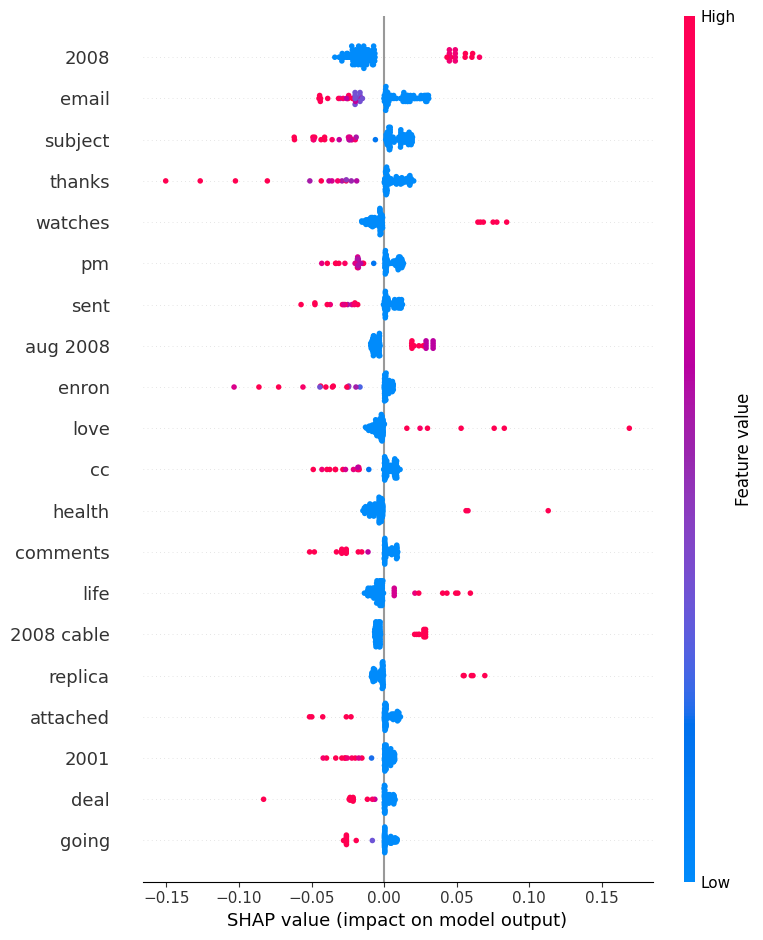


--- SHAP Local Explanations (Waterfall Plots for 3 instances) ---

Explaining prediction for test instance 0:
Original Text (first 200 chars): attached is the "final" counterparty matrix that is going to be uploaded into eol. please carefully review the tab that corresponds to your area of expertise (i.e. credit, legal, tax, contracts) or th
True Label: 0, Predicted Label: 0, Predicted Prob (Phish): 0.0334


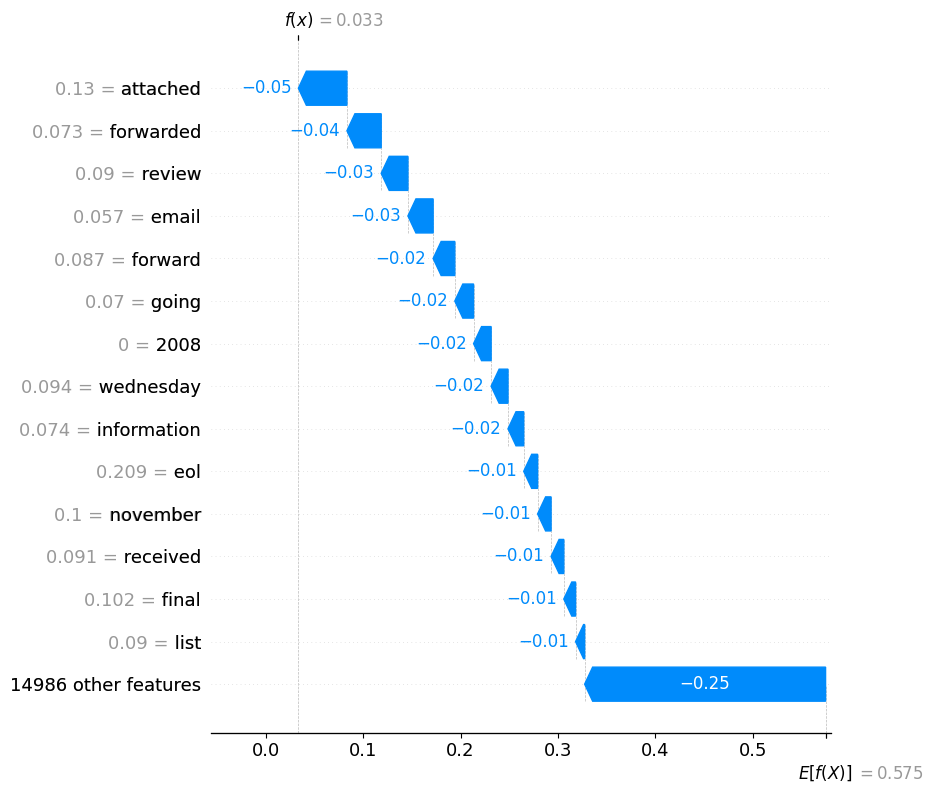


Explaining prediction for test instance 1:
Original Text (first 200 chars): so many parents has many benefits. report says.at the beach her kids it's chasing butterflies, playing withis an important one," said dr. kenneth many parentsand parents alike. one day a week. contrib
True Label: 1, Predicted Label: 1, Predicted Prob (Phish): 0.5192


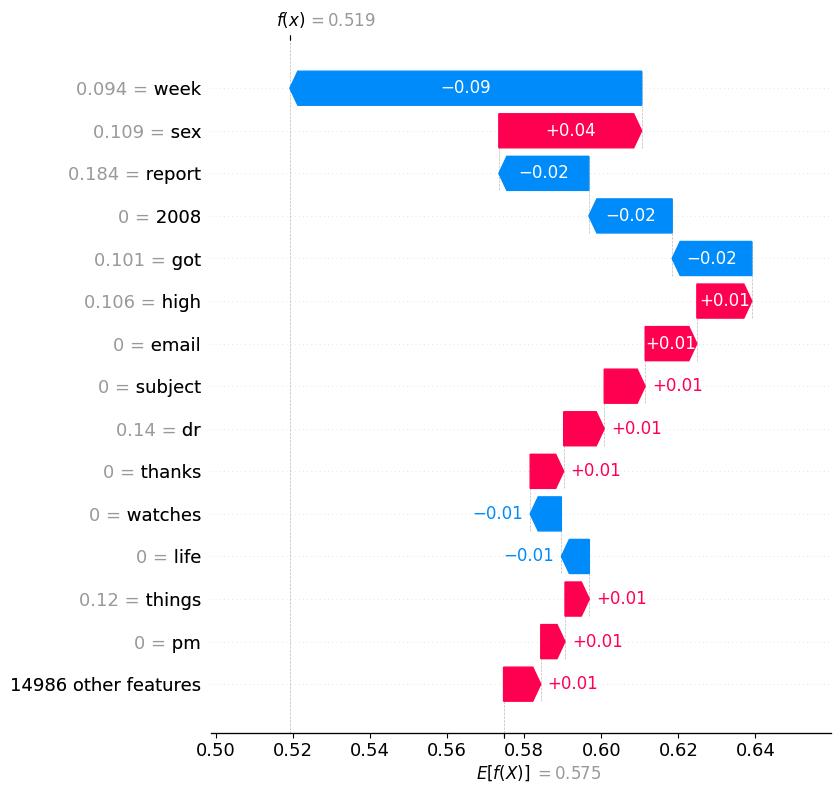


Explaining prediction for test instance 2:
Original Text (first 200 chars): b zqq u nn y dr hh u vuw gs on psk line fa lwh st ship zg ping. us licens bmh ed. overnight ship hgm ping. gr of eat pric aw es.
True Label: 1, Predicted Label: 1, Predicted Prob (Phish): 0.9750


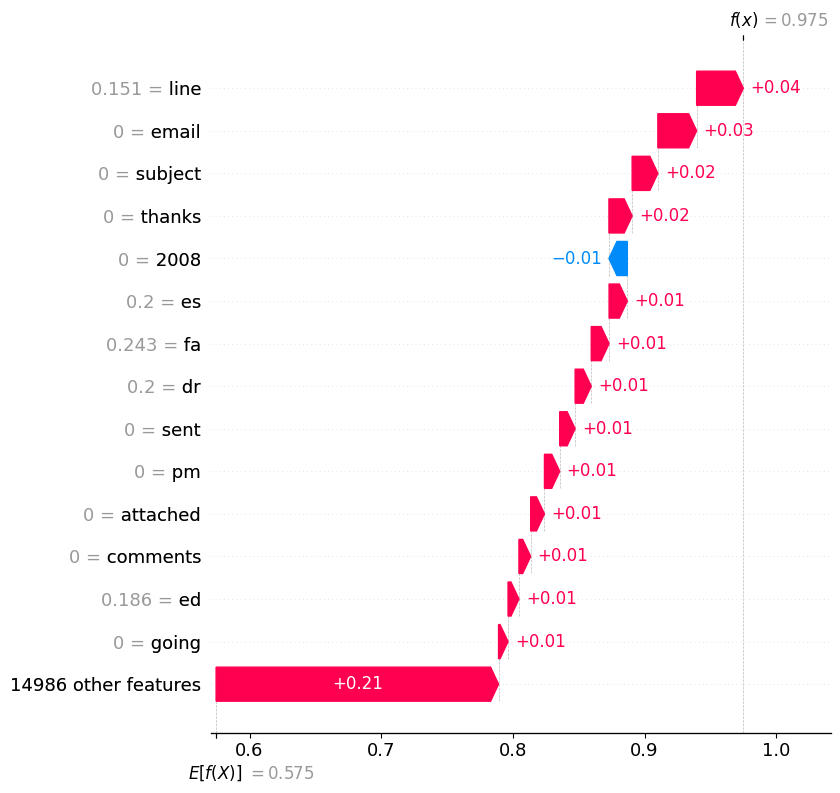

In [14]:
if shap_values_test is not None and 'X_test_subset_for_shap' in globals():

    # Get feature names from TF-IDF
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # --- Global Feature Importance: Summary Plot ---
    print("\n--- SHAP Summary Plot (Global Feature Importance) ---")
    # The summary plot shows the impact of all features.
    # For this plot, shap_values_test should be (num_samples, num_features)
    # and X_test_subset_for_shap should also be (num_samples, num_features) with feature names as columns
    try:
        shap.summary_plot(shap_values_test, X_test_subset_for_shap, feature_names=feature_names, max_display=20)
        plt.show()

    except Exception as e:
        print(f"Error generating SHAP summary plot: {e}")
        print("Ensure shap_values_test and X_test_subset_for_shap have compatible shapes and feature names are available.")

    # --- Local Explanations for Individual Predictions ---
    # Let's explain a few instances from the subset we calculated SHAP values for.
    # Get the original text for these instances if df_test_text is available
    original_texts_subset = []
    if 'df_test_text' in globals() and not df_test_text.empty and FEATURE_TEXT_COLUMN in df_test_text.columns:

        # Align with the subset used for SHAP calculation (first `subset_size_shap` from test set)
        original_texts_subset = df_test_text[FEATURE_TEXT_COLUMN].iloc[X_test_subset_for_shap.index].tolist()

    num_explanations_to_show = min(3, subset_size_shap)
    print(f"\n--- SHAP Local Explanations (Waterfall Plots for {num_explanations_to_show} instances) ---")

    # For waterfall plots, we often use an Explanation object if available and use one instance at a time.
    # If shap_values_test_obj was successfully created:
    if 'shap_values_test_obj' in globals() and shap_values_test_obj is not None:
        for i in range(num_explanations_to_show):
            print(f"\nExplaining prediction for test instance {X_test_subset_for_shap.index[i]}:")

            if original_texts_subset and i < len(original_texts_subset):
                print(f"Original Text (first 200 chars): {original_texts_subset[i][:200]}")

            true_label_instance = y_test_labels[X_test_subset_for_shap.index[i]]
            pred_proba_instance = rf_model.predict_proba(X_test_tfidf[X_test_subset_for_shap.index[i]])[0][1] # Prob of class 1
            pred_label_instance = rf_model.predict(X_test_tfidf[X_test_subset_for_shap.index[i]])[0]
            print(f"True Label: {true_label_instance}, Predicted Label: {pred_label_instance}, Predicted Prob (Phish): {pred_proba_instance:.4f}")

            # Use the shap_values_test_obj directly if explaining for positive class (output_index=1)
            # shap_values_test_obj is an Explanation object. We need to select the output for class 1.
            try:
                # Create a new Explanation object for the specific instance and class
                # Base value is often explainer.expected_value[1] for class 1
                expected_value_class1 = shap_explainer.expected_value
                if isinstance(expected_value_class1, (list, np.ndarray)) and len(expected_value_class1) == 2:
                    expected_value_class1 = expected_value_class1[1]

                # Create an Explanation object for a single instance and single class output
                instance_explanation = shap.Explanation(
                    values=shap_values_test[i,:], # SHAP values for this instance, for class 1
                    base_values=expected_value_class1,
                    data=X_test_subset_for_shap.iloc[i], # Feature values for this instance
                    feature_names=feature_names
                )

                shap.plots.waterfall(instance_explanation, max_display=15)
                plt.show()

            except Exception as e:
                print(f"Error generating waterfall plot for instance {i}: {e}")
                print("Try force plot as an alternative for this instance.")

                try:
                    # Force plot for one instance (for class 1)
                    shap.force_plot(expected_value_class1,
                                    shap_values_test[i,:],
                                    X_test_subset_for_shap.iloc[i,:],
                                    feature_names=feature_names,
                                    matplotlib=True, show=True) # Use matplotlib=True to make it render directly
                    # plt.show() # May not be needed if matplotlib=True, show=True works

                except Exception as e2:
                    print(f"Error generating force plot for instance {i}: {e2}")

    else:
        print("Could not generate local waterfall/force plots as shap_values_test_obj is not available.")
        print("This might happen if SHAP value calculation had issues or used a different structure.")

else:
    print("SHAP values not calculated or test data subset not available. Cannot visualise.")